In [1]:
import numpy as np
import re
import glob
import itertools
import pickle
import random
import multiprocessing
import matplotlib.pyplot as plt
import imageio
from mpl_toolkits.mplot3d import Axes3D
from pathlib import Path

from load_pfm import load_pfm
from utils import get_3d_pos_xy

In [57]:
import matplotlib as mpl
from matplotlib import cm
from skimage.color import hsv2rgb

In [189]:
disparity, _ = load_pfm('/datasets/disparity/TRAIN/A/0376/right/0009.pfm')
disparity_next_frame, _ = load_pfm('/datasets/disparity/TRAIN/A/0376/right/0010.pfm')
disparity_change, _ = load_pfm('/data/disparity_change/TRAIN/A/0376/into_future/right/0009.pfm')
optical_flow, _ = load_pfm('/data/optical_flow/TRAIN/A/0376/into_future/right/OpticalFlowIntoFuture_0009_R.pfm')
image = imageio.imread('/datasets/frames_finalpass/TRAIN/A/0376/right/0009.png')[:, :, :-1]
image_next_frame = imageio.imread('/datasets/frames_finalpass/TRAIN/A/0376/right/0010.png')[:, :, :-1]

In [224]:
focal_length = 1050.
optical_flow = optical_flow[:, :, :2]
depth = focal_length / disparity

In [191]:
pi = 3.14159
h = optical_flow.shape[0]
w = optical_flow.shape[1]

flow_degree = np.zeros((h, w))

for i in range(h):
    for j in range(w):
        x_vec = optical_flow[i, j, 0]
        y_vec = optical_flow[i, j, 1]
        d = np.arctan(y_vec / (x_vec+1e-10))
        if x_vec > 0:
            flow_degree[i, j] = d if y_vec > 0 else (2 * pi - d)
        else :
            flow_degree[i, j] = (pi - d) if y_vec > 0 else (pi + d)

flow_degree = (flow_degree - flow_degree.min()) / (flow_degree.max()-flow_degree.min())

flow_img_hsv = np.stack((flow_degree, np.ones((h, w))*0.8, np.ones((h, w))), 2)
flow_img_rgb = hsv2rgb(flow_img_hsv)

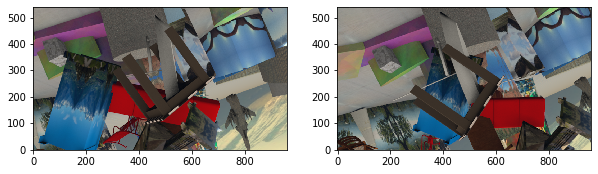

In [192]:
fig, axes = plt.subplots(1, 2, figsize=(10, 20))
ax0, ax1 = axes.ravel()
ax0.imshow(image)
ax0.invert_yaxis()
ax1.imshow(image_next_frame)
ax1.invert_yaxis()

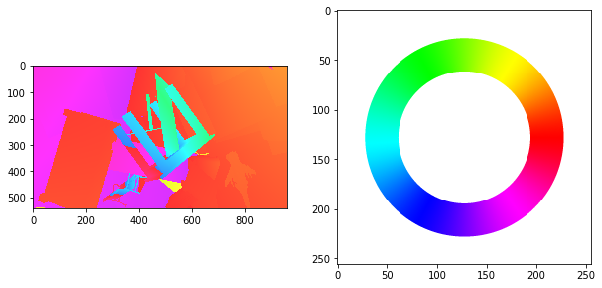

In [221]:
fig, axes = plt.subplots(1, 2, figsize=(10, 10))
ax0, ax1 = axes.ravel()
ax0.imshow(flow_img_rgb)
color_wheel = imageio.imread("/home/tony/SceneFlow/hsv_colorwheel.png")
ax1.imshow(color_wheel)

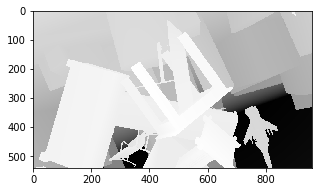

In [229]:
plt.figure(figsize=(5, 10))
depth_normalize = np.log(depth)
depth_normalize = (depth_normalize - depth_normalize.min()) / (depth_normalize.max()-depth_normalize.min())
depth_normalize = 1. - depth_normalize
plt.imshow(np.stack((depth_normalize, depth_normalize, depth_normalize), 2))

In [230]:
data_dir = "/home/tony/datasets/flyingthings3D_35_20k_2k_8192"
file_paths = sorted(list(Path(data_dir).glob('*')))
file_paths

[PosixPath('/home/tony/datasets/flyingthings3D_35_20k_2k_8192/TEST_A_0000_left_0006-0.npz'),
 PosixPath('/home/tony/datasets/flyingthings3D_35_20k_2k_8192/TEST_A_0000_left_0007-0.npz'),
 PosixPath('/home/tony/datasets/flyingthings3D_35_20k_2k_8192/TEST_A_0000_left_0008-0.npz'),
 PosixPath('/home/tony/datasets/flyingthings3D_35_20k_2k_8192/TEST_A_0000_left_0009-0.npz'),
 PosixPath('/home/tony/datasets/flyingthings3D_35_20k_2k_8192/TEST_A_0000_left_0010-0.npz'),
 PosixPath('/home/tony/datasets/flyingthings3D_35_20k_2k_8192/TEST_A_0000_left_0011-0.npz'),
 PosixPath('/home/tony/datasets/flyingthings3D_35_20k_2k_8192/TEST_A_0000_left_0012-0.npz'),
 PosixPath('/home/tony/datasets/flyingthings3D_35_20k_2k_8192/TEST_A_0000_left_0013-0.npz'),
 PosixPath('/home/tony/datasets/flyingthings3D_35_20k_2k_8192/TEST_A_0000_left_0014-0.npz'),
 PosixPath('/home/tony/datasets/flyingthings3D_35_20k_2k_8192/TEST_A_0006_right_0006-0.npz'),
 PosixPath('/home/tony/datasets/flyingthings3D_35_20k_2k_8192/TEST_A_

In [ ]:
file = np.load(file_paths[0])
point1 = file['points1']
point2 = file['points2']
stereo1 = file['color1']
stereo2 = file['color2'] 
flow = file['flow']
mask = file['valid_mask1']

In [244]:
pix1_x = point1[:, 0]
pix1_y = point1[:, 1]
pix1_z = point1[:, 2]

pix1_x = (pix1_x - pix1_x.min()) / (pix1_x.max() - pix1_x.min())
pix1_x = (pix1_x * (w-1)).astype(np.int16)
pix1_y = (pix1_y - pix1_y.min()) / (pix1_y.max() - pix1_y.min())
pix1_y = (pix1_y * (h-1)).astype(np.int16)
pix1_z = (pix1_z - pix1_z.min()) / (pix1_z.max() - pix1_z.min())

depth_img = np.zeros((h, w))
for i in range(pix1_x.shape[0]):
    depth_img[pix1_y[i], pix1_x[i]] = pix1_z[i]

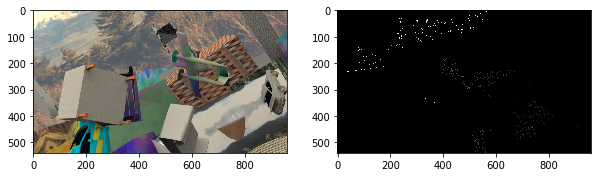

In [245]:
image = imageio.imread('/datasets/frames_finalpass/TRAIN/A/0000/left/0006.png')[:, :, :-1]
disparity, _ = load_pfm('/datasets/disparity/TRAIN/A/0000/right/0006.pfm')
optical_flow, _ = load_pfm('/data/optical_flow/TRAIN/A/0000/into_future/right/OpticalFlowIntoFuture_0006_R.pfm')

fig, axes = plt.subplots(1, 2, figsize=(10, 10))
ax0, ax1 = axes.ravel()

ax0.imshow(image)
ax1.imshow(np.stack((depth_img, depth_img, depth_img), 2))

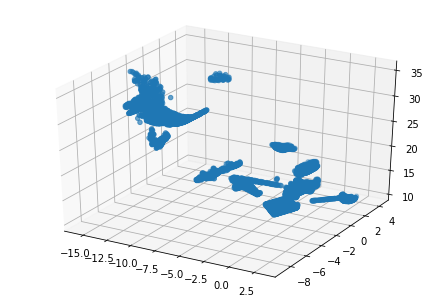

In [44]:
fig1 = plt.figure()
ax1 = Axes3D(fig1)

ax1.scatter3D(point1[:, 0], point1[:, 1], point1[:, 2], cmap='Blues')
plt.show()

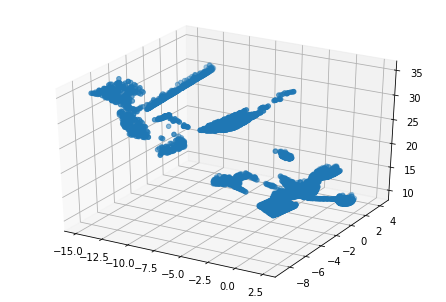

In [46]:
fig2 = plt.figure()
ax2 = Axes3D(fig2)

ax2.scatter3D(point2[:, 0], point2[:, 1], point2[:, 2], cmap='Blues')
plt.show()